In [5]:
# import modules
import tensorflow as tf
from tensorflow import keras

from keras import layers, Sequential, utils
from keras.applications import VGG19

from keras.applications import InceptionV3

import numpy as np
import cv2

In [14]:
# import dataset

import pathlib

data_dir = "C:\\Abhishek_Data\\My_Data\\Datasets\\Classification\\PetImages"
data_dir = pathlib.Path(data_dir)

batch_size = 16
img_width = 224
img_height = 224

train_ds = keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2,
    subset="training",
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    seed=123
)

val_ds = keras.utils.image_dataset_from_directory(
    data_dir, 
    validation_split=0.2,
    subset="validation",
    batch_size=batch_size, 
    image_size=(img_height, img_width),
    seed=123
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)



Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.
['Cat', 'Dog']


In [16]:
# data augmentation

data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomCrop(height=img_height, width=img_width)
  ]
)

In [17]:
model = Sequential()
#model.add(data_augmentation)
model.add(InceptionV3(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3)))

for layer in model.layers:
    layer.trainable = False

model.add(layers.Flatten())

model.add(layers.Dense(1024))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(64))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.2))

model.add(layers.Dense(2))
model.add(layers.BatchNormalization())
model.add(layers.Activation("softmax"))

model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dense_6 (Dense)             (None, 1024)              52429824  
                                                                 
 batch_normalization_288 (Ba  (None, 1024)             4096      
 tchNormalization)                                               
                                                                 
 activation_288 (Activation)  (None, 1024)             0         
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                      

In [18]:
# model training (adding and retraining top classification layers not fine tuning)
import datetime, os

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[tensorboard_callback]
)

1172/1172 [==============================] - 189s 157ms/step - loss: 0.6146 - accuracy: 0.6602 - val_loss: 0.5664 - val_accuracy: 0.7105


Confusion Matrix


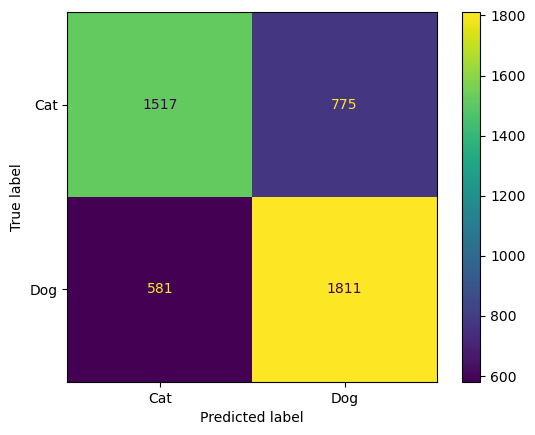

Classification Report
              precision    recall  f1-score   support

         Cat       0.72      0.66      0.69      2292
         Dog       0.70      0.76      0.73      2392

    accuracy                           0.71      4684
   macro avg       0.71      0.71      0.71      4684
weighted avg       0.71      0.71      0.71      4684



In [19]:
# accuracy metrics using model in memory (not saved on disk)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

target_names = val_ds.class_names 

y_true = []
y_pred = []

for images, labels in val_ds:
    y_true = y_true + labels.numpy().tolist() 

    temp_pred = model.predict(images, verbose=0)
    temp_pred = np.argmax(temp_pred, axis = 1)
    y_pred = y_pred + temp_pred.tolist()

print('Confusion Matrix')  
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=val_ds.class_names)
plt.show()


print('Classification Report') 
print(classification_report(y_true, y_pred, target_names=target_names))